<a href="https://colab.research.google.com/github/AVerz26/MBA_TCC/blob/main/TCC_Andr%C3%A9_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Influência de fatores ambientais na produção de ovos utilizando Random Forest para análise dos mesmos.

# Dados históricos referente ao galpão climatizado existente em um dos produtores da granja localizado no município de Céu Azul - PR, do qual temos a linhagem Bovans com idade de 62 semanas.
# As medições dos fatores foram feitas a partir dos seguintes instrumentos:
# Concentração de amônia - Detector de NH3, medido ao longo da rua e feito a média de todos os pontos
# Temperatura - Medido por um termômetro digital e feito a média de todos os pontos
# Umidade - Higrômetro digital
# Luz - Luxímetro feito também a média de todos os pontos coletados
# Contagem de Ovos - Feito dentro da unidade

# Parametrizamos o valor da produção de ovos, pois dependerá diretamente do número de aves (viabilidade), sendo a % Padrão Obtido igual a divisão entre Qte. Produzida/Viabilidade.

# Importação e tratamento dos dados

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score

In [14]:
df_prod = pd.read_excel('DADOS_POSTURA_AMBIENTE.xlsx', sheet_name = "Planilha1")
df_prod.head()

,Data,Idade,Viabilidade,Amonia (ppm),Temperatura (°C),Umidade (%),Luz (lux),Produção Ovos,Pad. Obt. Obtido (%),Ovos Fissurados (%)
0,2023-09-01,44,15067,14,23,68,83,14437,0.958187,5.285714
1,2023-09-02,45,15055,14,21,62,85,14051,0.933311,6.000000
2,2023-09-03,45,15048,17,26,50,61,13989,0.929625,6.571429
3,2023-09-04,45,15042,15,26,44,69,13178,0.876080,11.000000
4,2023-09-05,45,15023,18,26,60,57,14132,0.940691,8.571429


In [15]:
column_name = 'Ovos Fissurados (%)'

index_to_drop = df_prod[df_prod[column_name] == df_prod[column_name].max()].index

# Excluir a linha com base no índice
df_prod = df_prod.drop(index_to_drop)

In [4]:
df_prod.describe()

,Data,Idade,Viabilidade,Amonia (ppm),Temperatura (°C),Umidade (%),Luz (lux),Produção Ovos,Pad. Obt. Obtido (%),Ovos Fissurados (%)
count,212,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,2023-12-15 22:04:31.698113280,59.561321,14086.858491,17.207547,26.023585,55.797170,60.556604,12148.136792,0.861263,11.394946
min,2023-09-01 00:00:00,44.000000,12860.000000,13.000000,19.000000,10.000000,26.000000,10123.000000,0.763640,4.571429
25%,2023-10-23 18:00:00,52.000000,13605.750000,15.000000,25.000000,50.000000,51.000000,11292.750000,0.812355,8.421429
50%,2023-12-15 12:00:00,59.500000,14169.000000,17.000000,26.000000,57.000000,60.000000,11990.500000,0.853970,10.571429
75%,2024-02-07 06:00:00,67.000000,14575.000000,19.000000,28.000000,65.000000,69.000000,13047.500000,0.903219,14.289286
max,2024-03-31 00:00:00,75.000000,15067.000000,23.000000,33.000000,89.000000,100.000000,14531.000000,0.973324,20.428571
std,NaN,8.828595,612.073176,2.113899,2.702362,14.680205,14.216391,1133.522081,0.055842,3.818206


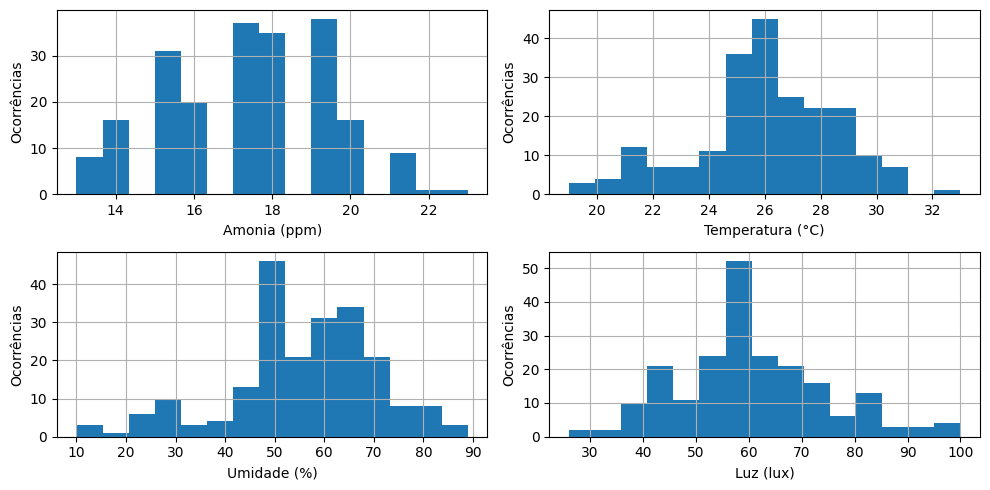

In [5]:
X = df_prod[['Amonia (ppm)', 'Temperatura (°C)', 'Umidade (%)', 'Luz (lux)']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

# Flattening the axes for easier iteration
axes = axes.flatten()

# Creating histograms and adding titles
for i, col in enumerate(X.columns):
    X[col].hist(bins=15, ax=axes[i])

    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Ocorrências")

# Adjusting layout
plt.tight_layout()

# Displaying the plot
plt.show()

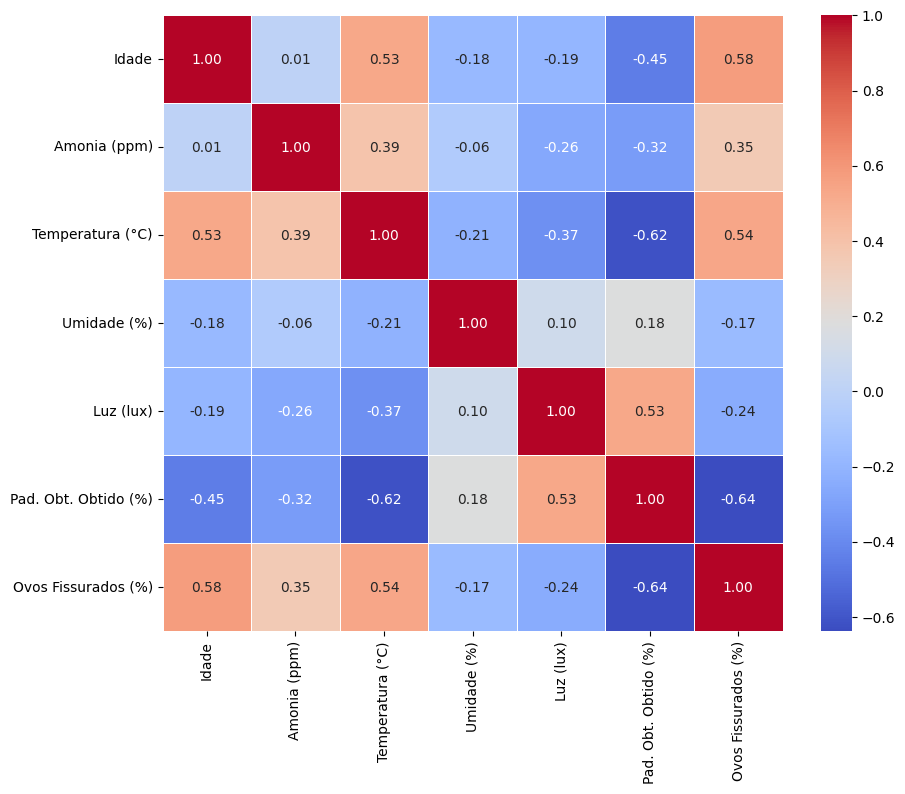

In [12]:
X = df_prod[['Idade', 'Amonia (ppm)', 'Temperatura (°C)', 'Umidade (%)', 'Luz (lux)', 'Pad. Obt. Obtido (%)', 'Ovos Fissurados (%)']]
correlacao_matriz = X.corr()

plt.figure(figsize=(10, 8))  # Ajuste o tamanho da figura conforme necessário
sns.heatmap(correlacao_matriz, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.savefig('mapa_de_correlacao.jpeg', format='jpeg', bbox_inches='tight', dpi=600)  # Use bbox_inches='tight' para evitar cortes
plt.show()

# Random Forest para estimativa do Padrão obtido


In [11]:
# Iremos utilizar a técnica Random Forest para prever o valor Padrão Obtido, a partir das variáveis citadas

X = df_prod[['Amonia (ppm)', 'Temperatura (°C)', 'Umidade (%)', 'Luz (lux)']]
y = df_prod['Pad. Obt. Obtido (%)']


# Previsão Padrão Obtido
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_regressor = RandomForestRegressor(max_depth=7, max_features=0.3,
                      n_estimators=95)
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE) Padrão Obtido: {mse:.4f}')
print(f'R-squared (R2) Padrão Obtido: {r2:.2f}')


Mean Squared Error (MSE) Padrão Obtido: 0.0017
R-squared (R2) Padrão Obtido: 0.51


In [9]:
# Tunar hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV as RSCV
import numpy as np

param_grid = {'n_estimators':np.arange(50,200,15),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9]}

model = RSCV(RandomForestRegressor(), param_grid, n_iter = 15).fit(X_train, y_train)
model = model.best_estimator_
print(model)

RandomForestRegressor(max_depth=7, max_features=0.30000000000000004,
                      n_estimators=95)


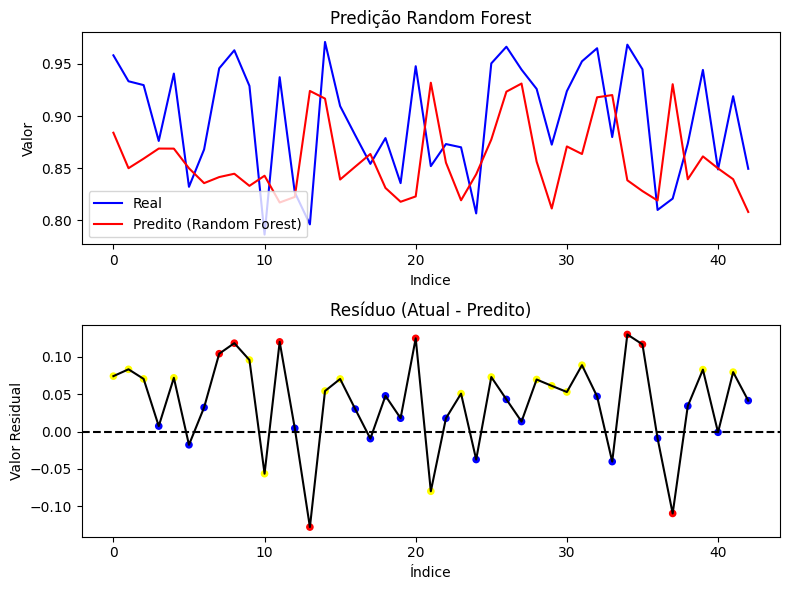

In [39]:
y = y[:len(y_pred)]

residual = y - y_pred

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

axs[0].plot(y, color='blue', label='Real')
axs[0].plot(y_pred, color='red', label='Predito (Random Forest)')
axs[0].set_title('Predição Random Forest')
axs[0].set_xlabel('Indice')
axs[0].set_ylabel('Valor')
axs[0].legend()

# Definindo os intervalos e as cores correspondentes
thresh_red = 0.10
thresh_yellow = 0.05

# Criando uma máscara para os diferentes intervalos
mask_red = (abs(residual) > thresh_red)
mask_yellow = (abs(residual) > thresh_yellow) & (abs(residual) <= thresh_red)
mask_lightblue = (abs(residual) <= thresh_yellow)
marker_size = 20

# Plotando os resíduos com cores diferentes para cada intervalo
axs[1].plot(residual, color='black', label='Resíduo')
axs[1].scatter(np.arange(len(residual)), residual, s=marker_size, color=np.where(mask_red, 'red', np.where(mask_yellow, 'yellow', 'blue')), label='Resíduo')

# Adicionando a linha de média residual
axs[1].axhline(0, color='black', linestyle='--', label='Média Residual')

# Configurando o título e os rótulos dos eixos
axs[1].set_title('Resíduo (Atual - Predito)')
axs[1].set_xlabel('Índice')
axs[1].set_ylabel('Valor Residual')


#axs[1].plot(residual, color='green', label='Resíduo')
#axs[1].axhline(0, color='black', linestyle='--', label='Média Residual')
#axs[1].set_title('Resíduo (Atual - Predito)')
#axs[1].set_xlabel('Indice')
#axs[1].set_ylabel('Valor Residual')
#axs[1].legend()

plt.tight_layout()
plt.show()


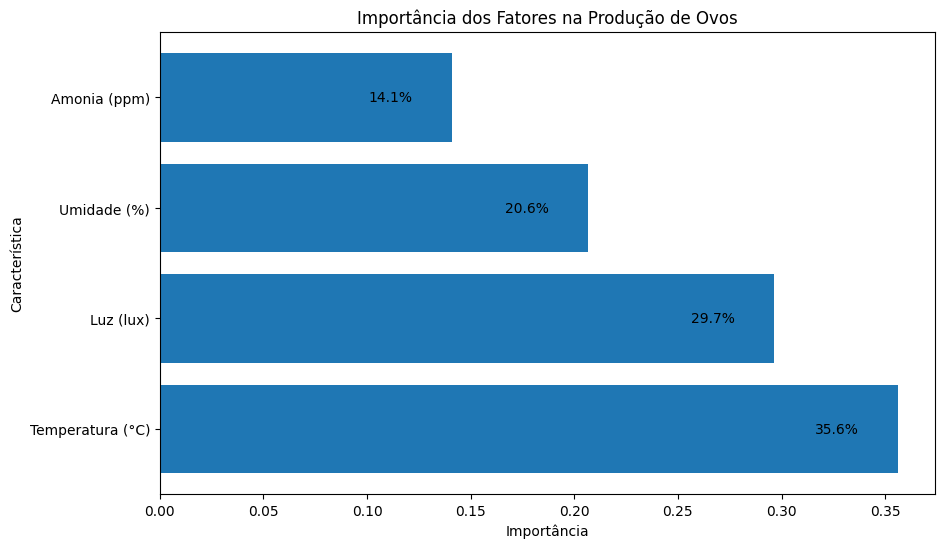

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

importancias_caracteristicas = rf_regressor.feature_importances_

df_importancias = pd.DataFrame({'Caracteristica': X_train.columns, 'Importancia': importancias_caracteristicas})
df_importancias = df_importancias.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
barras = plt.barh(df_importancias['Caracteristica'], df_importancias['Importancia'])
plt.xlabel('Importância')
plt.ylabel('Característica')
plt.title('Importância dos Fatores na Produção de Ovos')

for barra, label in zip(barras, df_importancias['Importancia']):
    plt.text(barra.get_width() - 0.04, barra.get_y() + barra.get_height() / 2, f'{label:.1%}', va='center', ha='left')
plt.savefig('importancia_padrao.jpeg', format='jpeg', dpi=600)  # Salvar o plot no formato .tiff
plt.show()


# Random Forest para estimativa dos Ovos fissurados

In [ ]:
# Previsão Ovos fissurados



X = df_prod[['Amonia (ppm)', 'Temperatura (°C)', 'Umidade (%)', 'Luz (lux)']]
w = df_prod['Ovos Fissurados (%)']

X_train, X_test, w_train, w_test = train_test_split(X, w, test_size=0.3, random_state=100)
rf_regressorw = RandomForestRegressor(max_depth=3, max_features=0.3,
                      max_samples=0.3, n_estimators=110)
rf_regressorw.fit(X_train, w_train)

w_pred = rf_regressorw.predict(X_test)
msew = mean_squared_error(w_test, w_pred)
r2w = r2_score(w_test, w_pred)

print(f'Mean Cross-validated Squared Error (MSE): {msew:.4f}')
print(f'Mean Cross-validated R-squared (R2): {r2w:.2f}')




In [27]:
# Tunar hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV as RSCV

param_grid = {'n_estimators':np.arange(50,200,15),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9],
              'max_samples': [0.3, 0.5, 0.8]}

model = RSCV(RandomForestRegressor(), param_grid, n_iter = 15).fit(X_train, w_train)
model = model.best_estimator_
print(model)

RandomForestRegressor(max_depth=9, max_features=0.30000000000000004,
                      max_samples=0.8, n_estimators=65)


In [ ]:
w = w[:len(w_pred)]

residual = w - w_pred

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

axs[0].plot(w, color='blue', label='Real')
axs[0].plot(w_pred, color='red', label='Predito (Random Forest)')
axs[0].set_title('Predição Random Forest')
axs[0].set_xlabel('Indice')
axs[0].set_ylabel('Valor')
axs[0].legend()

axs[1].plot(residual, color='green', label='Resíduo')
axs[1].axhline(np.mean(residual), color='black', linestyle='--', label='Média Residual')
axs[1].set_title('Resíduo (Atual - Predito)')
axs[1].set_xlabel('Indice')
axs[1].set_ylabel('Valor Residual')
#axs[1].legend()

plt.tight_layout()
plt.show()


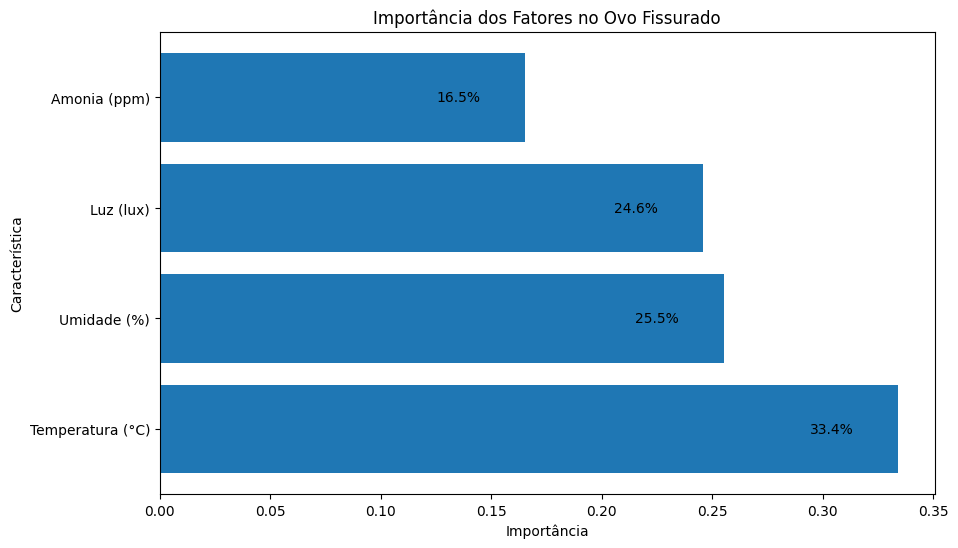

In [52]:
importancias_caracteristicas = rf_regressorw.feature_importances_

df_importancias = pd.DataFrame({'Caracteristica': X_train.columns, 'Importancia': importancias_caracteristicas})
df_importancias = df_importancias.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
barras = plt.barh(df_importancias['Caracteristica'], df_importancias['Importancia'])
plt.xlabel('Importância')
plt.ylabel('Característica')
plt.title('Importância dos Fatores no Ovo Fissurado')

for barra, label in zip(barras, df_importancias['Importancia']):
    plt.text(barra.get_width() - 0.04, barra.get_y() + barra.get_height() / 2, f'{label:.1%}', va='center', ha='left')
plt.savefig('importancia_fissurado.jpeg', format='jpeg', dpi=600)  # Salvar o plot no formato .tiff
plt.show()

# XGBoost

RMSE: 3.086400656954672
R²: 0.33044074276654856


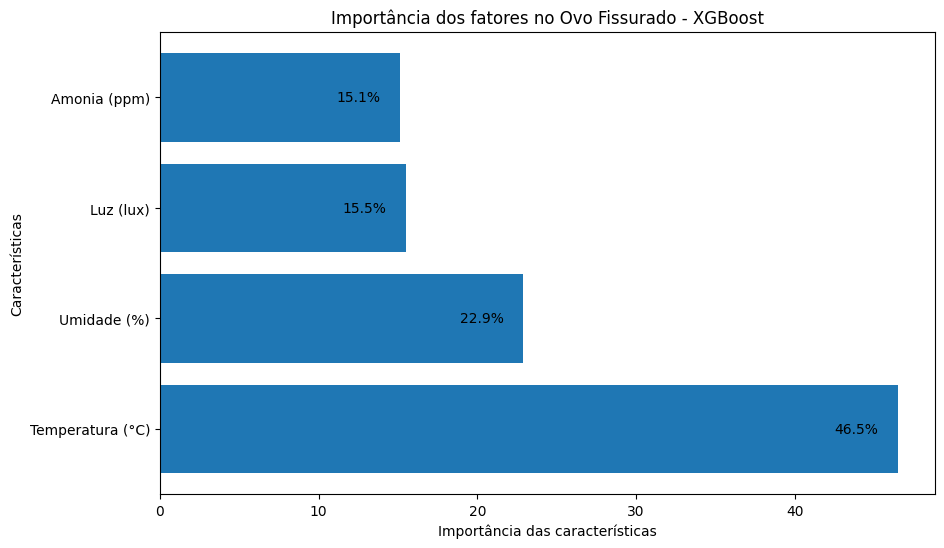

In [37]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


X = df_prod[['Amonia (ppm)', 'Temperatura (°C)', 'Umidade (%)', 'Luz (lux)']]
y = df_prod['PAd. Obt. Obtido (%)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
columns = X.columns  # Salva o nome das colunas antes da transformação

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Inicializando o modelo XGBoost
model = xgb.XGBRegressor()

# Treinando o modelo
model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calculando RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculando R²
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

# Obtendo a importância das características
importances = model.feature_importances_

# Calculando a porcentagem de importância de cada característica
total_importance = np.sum(importances)
importance_percentages = importances / total_importance * 100

# Ordenando as importâncias e os nomes das características de acordo com os índices
sorted_indices = np.argsort(importances)
sorted_indices = sorted_indices[::-1]  # invertendo a ordem

# Ordenando as importâncias e os nomes das características de acordo com os índices
sorted_importances = importances[sorted_indices] * 100
sorted_columns = np.array(columns)[sorted_indices]

# Plotando importâncias das características
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_columns, sorted_importances)
plt.xlabel('Importância das características')
plt.ylabel('Características')
plt.title('Importância dos fatores no Ovo Fissurado - XGBoost')

# Adicionando os valores dentro das barras
for bar, value in zip(bars, sorted_importances):
    plt.text(bar.get_width()-4, bar.get_y() + bar.get_height()/2, f'{value:.1f}%',
             va='center', ha='left')
plt.savefig('importancia_fissurado_xgboost.jpeg', format='jpeg', dpi=600)  # Salvar o plot no formato .tiff
plt.show()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
RMSE: 2.7327330543465043
R²: 0.4750972678715716


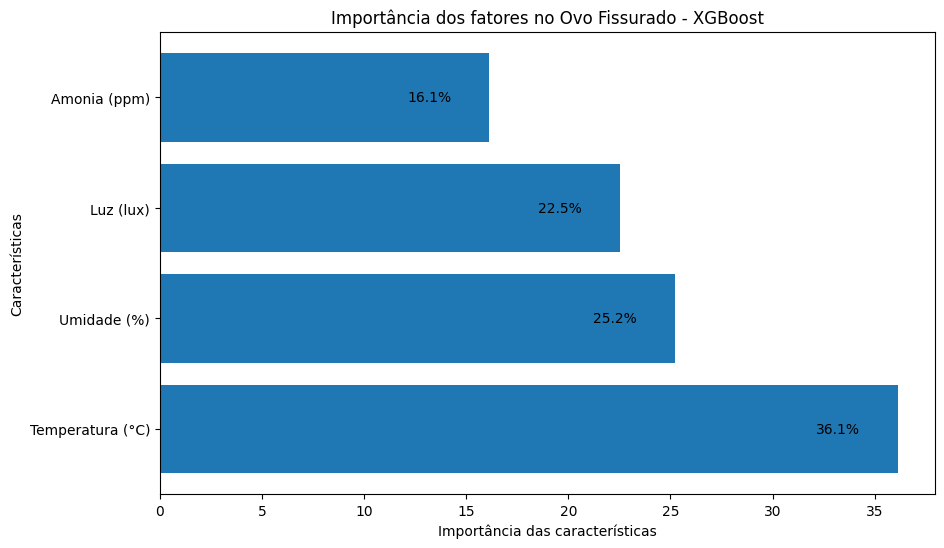

In [49]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


X = df_prod[['Amonia (ppm)', 'Temperatura (°C)', 'Umidade (%)', 'Luz (lux)']]
y = df_prod['Ovos Fissurados (%)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
columns = X.columns  # Salva o nome das colunas antes da transformação

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Inicializar e ajustar RandomizedSearchCV
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=50, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Melhor modelo
best_model = random_search.best_estimator_

print(best_model)

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Calcular RMSE e R²
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

# Obtendo a importância das características
importances = best_model.feature_importances_

# Calculando a porcentagem de importância de cada característica
total_importance = np.sum(importances)
importance_percentages = importances / total_importance * 100

# Ordenando as importâncias e os nomes das características de acordo com os índices
sorted_indices = np.argsort(importances)
sorted_indices = sorted_indices[::-1]  # invertendo a ordem

# Ordenando as importâncias e os nomes das características de acordo com os índices
sorted_importances = importances[sorted_indices] * 100
sorted_columns = np.array(columns)[sorted_indices]

# Plotando importâncias das características
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_columns, sorted_importances)
plt.xlabel('Importância das características')
plt.ylabel('Características')
plt.title('Importância dos fatores no Ovo Fissurado - XGBoost')

# Adicionando os valores dentro das barras
for bar, value in zip(bars, sorted_importances):
    plt.text(bar.get_width()-4, bar.get_y() + bar.get_height()/2, f'{value:.1f}%',
             va='center', ha='left')
plt.savefig('importancia_fissurado_xgboost.jpeg', format='jpeg', dpi=600)  # Salvar o plot no formato .jpeg
plt.show()
